<a href="https://colab.research.google.com/github/Savvythelegend/MLE/blob/main/from_scratch/principal_component_analysis_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis (PCA) from Scratch

### Background
Principal Component Analysis (PCA) is a simple dimensionality reduction technique that can capture linear correlations between the features. For a given (standardized) data, PCA can be calculated by eigenvalue decomposition of covariance (or correlation) matrix of the data, or Singular Value Decomposition (SVD) of the data matrix. The data standardization includes mean removal and variance normalization.

In [136]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']
n_samples, n_features = X.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 150
Number of features: 4


In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

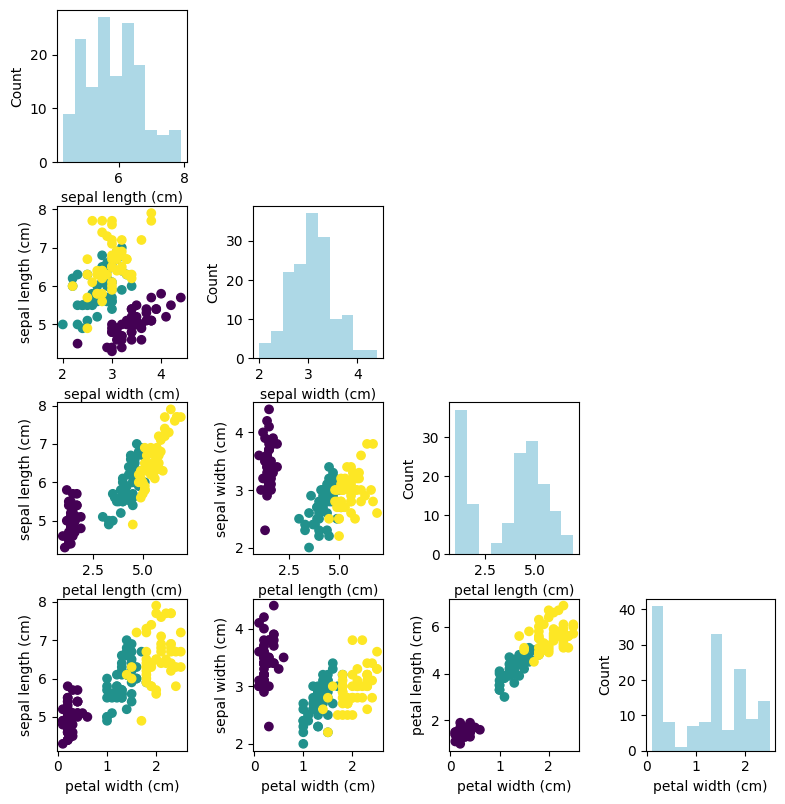

In [23]:
fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (8, 8))
fig.tight_layout()

"""
This loop creates pairwise scatter plots using only the upper triangle of a subplot grid.

np.triu_indices_from(ax, k=1) gives the (i, j) index pairs where i < j (upper triangle),
to avoid redundant scatter plots and keep the grid clean.

zip(*...) unpacks the tuple of arrays into separate arguments, pairing corresponding i and j.

For each (i, j):
- ax[j, i] is used to plot feature j vs feature i.
- ax[i, j] is turned off to avoid mirroring the same plot.
"""

names = iris.feature_names

for i, j in zip(*np.triu_indices_from(ax, k=1)):
    ax[j, i].scatter(X[:, j], X[:, i], c = y)
    ax[j, i].set_xlabel(names[j])
    ax[j, i].set_ylabel(names[i])
    ax[i, j].set_axis_off()

for i in range(n_features):
    ax[i, i].hist(X[:, i], color = 'lightblue')
    ax[i, i].set_ylabel('Count')
    ax[i, i].set_xlabel(names[i])

### PCA with the covariance method
##### The following step-by-step guide explains the general framework for computing PCA using the covariance method.

In [29]:
def mean(x): # np.mean(X, axis = 0)
    return sum(x)/len(x)

def std(x): # np.std(X, axis = 0)
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

def Standardize_data(X):
    return (X - mean(X))/std(X)

X_std = Standardize_data(X)

In [35]:
def covariance(x):
  """
    Computes sample covariance matrix using (X^T @ X) / (n - 1)
    n - 1 (Bessel's correction) ensures unbiased estimate from sample
  """
  return (x.T @ x) / (x.shape[0] - 1)

cov_mat = covariance(X_std)  #np.cov(X_std.T)

In [38]:
from numpy.linalg import eig
eigvalues, eigvectors = eig(cov_mat)
max_abs_idx = np.argmax(np.abs(eigvectors),axis=0)

In [40]:
eigvectors

array([[ 0.52106591, -0.37741762, -0.71956635,  0.26128628],
       [-0.26934744, -0.92329566,  0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161,  0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199,  0.63427274,  0.52359713]])

In [41]:
max_abs_idx

array([2, 1, 0, 2])

In [74]:
eigvectors

array([[ 0.52106591, -0.37741762, -0.71956635,  0.26128628],
       [-0.26934744, -0.92329566,  0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161,  0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199,  0.63427274,  0.52359713]])

In [73]:
eigvalues

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

Interpretation:

| PC  | Eigenvalue | % Variance Explained      |
| --- | ---------- | ------------------------- |
| PC1 | 2.938      | (2.938 / 4) × 100 ≈ 73.4% |
| PC2 | 0.920      | (0.920 / 4) × 100 ≈ 23.0% |
| PC3 | 0.148      | (0.148 / 4) × 100 ≈ 3.7%  |
| PC4 | 0.021      | (0.021 / 4) × 100 ≈ 0.5%  |


> (standardized features → total variance = 4)
> PC1 and PC2 together explain **~96.4%** of the variance
> So we can reduce to 2 dimensions without losing much information.

In [81]:
from numpy.linalg import eig

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_mat)

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors 
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]


### Rearrange the eigenvectors and eigenvalues
Here, we sort eigenvalues in descending order.

In [97]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs)

[(np.float64(2.9380850501999918), array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654])), (np.float64(0.920164904162487), array([0.37741762, 0.92329566, 0.02449161, 0.06694199])), (np.float64(0.14774182104494785), array([ 0.71956635, -0.24438178, -0.14212637, -0.63427274])), (np.float64(0.020853862176462023), array([-0.26128628,  0.12350962,  0.80144925, -0.52359713]))]


In [107]:
#Select top k eigenvectors
k = 2
W = eig_vecs_sorted[:k, :] # Projection matrix
print(f"Pricipal components are:\n{W[0]} and\n{W[1]}\nShape:{W.shape}")

Pricipal components are:
[ 0.52106591 -0.26934744  0.5804131   0.56485654] and
[0.37741762 0.92329566 0.02449161 0.06694199]
Shape:(2, 4)


Explained variance: [72.96 22.85  3.67  0.52]
Cumulative explained variance: [ 72.96  95.81  99.48 100.  ]



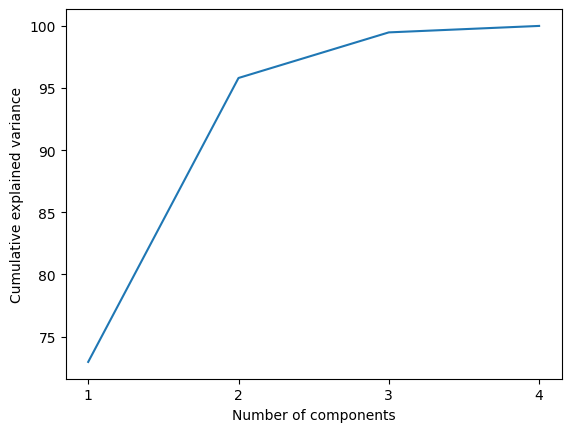

In [116]:
eig_vals_total = sum(eig_vals)
explaind_vairance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explaind_vairance,2)
cum_explained_variance = np.cumsum(explained_variance)
print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

plt.plot(np.arange(1,n_features+1), cum_explained_variance)
plt.xticks(np.arange(1,n_features+1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
print()
plt.show()

### Project the data
Finally, we can transform the data  X
  via the projection matrix  W
  to obtain a  k
 -dimensional feature subspace.

In [121]:
X_proj = X_std.dot(W.T)
X_proj.shape

(150, 2)

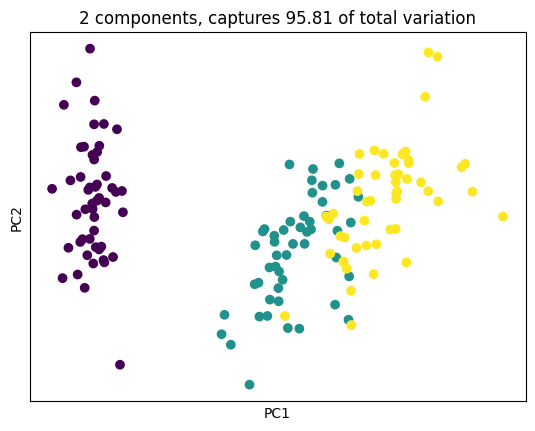

In [122]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))
plt.show()

In continute, we will put all of the above steps into a single class, train it and verify the result with Scikit-learn's PCA model.

In [126]:
class MyPCA:

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # Standardize data
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X_std = (X - self.mean) / self.scale

        # Eigendecomposition of covariance matrix
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)

        # Adjusting the eigenvectors that are largest in absolute value to be positive
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs*signs[np.newaxis,:]
        eig_vecs = eig_vecs.T

        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

        self.components = eig_vecs_sorted[:self.n_components,:]

        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]

        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)

        return X_proj
# ---------------------------------------------------------
my_pca = MyPCA(n_components = 2).fit(X)

print('Components:\n', my_pca.components)
print('Explained variance ratio from scratch:\n', my_pca.explained_variance_ratio)
print('Cumulative explained variance from scratch:\n', my_pca.cum_explained_variance)

X_proj = my_pca.transform(X)
print('Transformed data shape from scratch:', X_proj.shape)

Components:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance ratio from scratch:
 [np.float64(0.7296244541329989), np.float64(0.22850761786701754)]
Cumulative explained variance from scratch:
 [0.72962445 0.95813207]
Transformed data shape from scratch: (150, 2)


### PCA with Scikit-Learn
In this section, we do PCA through Scikit-Learn package as the following.

Components:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance ratio:
 [0.72962445 0.22850762]
Cumulative explained variance:
 [0.72962445 0.95813207]
Transformed data shape: (150, 2)


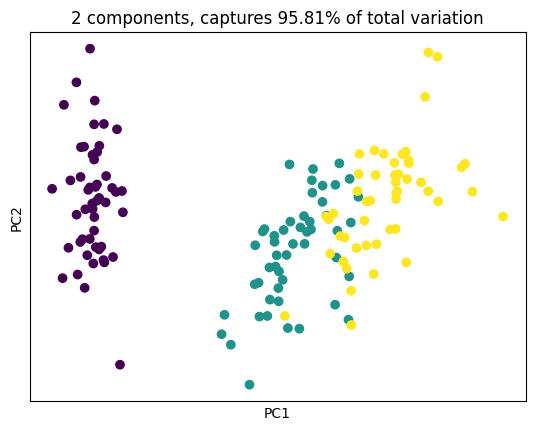

In [135]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(X_std)

print('Components:\n', pca.components_)
print('Explained variance ratio:\n', pca.explained_variance_ratio_)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance:\n', cum_explained_variance)

X_pca = pca.transform(X_std) # Apply dimensionality reduction to X.
print('Transformed data shape:', X_pca.shape)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y)
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {}% of total variation'.format(cum_explained_variance[1].round(4)*100))
plt.show()